# Transfer learning for video engagement classification with MoViNet

This notebook is forked from Tensorflow implementation of transfer learning on MoViNets (Mobile Video Networks), which is a family of efficient video classification models, supporting inference on streaming video. You can check the official tutorial on [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet).

## Packages

In [26]:
#!pip install remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official
#!pip install split-folders

In [27]:
import random
from pathlib import Path
import itertools
import collections

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import os
from glob import glob1


from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

In [28]:
!nvidia-smi

Fri Feb 10 13:42:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:3E:00.0 Off |                    0 |
| N/A   26C    P0    51W / 300W |  31928MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load data

If you already downloaded our engagement dataset, create 10-sec clips from the videos using the [../data-pipeline/slice_based_on_levels.ipynb](../data-pipeline/slice_based_on_levels.ipynb). The following cell will then create a train/test split automatically

In [1]:
# Create the Dataset in FrameGenerator Format

"""
engagement_levels = ["-2", "-1", "0", "1", "2"]
!mkdir ../engagement-slices/movinet_dataset
for e in engagement_levels:
    !mkdir {"../engagement-slices/movinet_dataset/%s" % e}

for i in range(4,9):
    for e in engagement_levels:
        for v in glob1("../engagement-slices/%d/%s" % (i, e),"*.mp4"):
            print(v)
            !cp {"../engagement-slices/%d/%s/%s" % (i, e, v)} {"../engagement-slices/movinet_dataset/%s" % e}
            
import splitfolders
splitfolders.ratio('../engagement-slices/movinet_dataset', output="output", seed=1337, ratio=(0.8, 0.2)) 
"""

'\nengagement_levels = ["-2", "-1", "0", "1", "2"]\n!mkdir ../engagement-slices/movinet_dataset\nfor e in engagement_levels:\n    !mkdir {"../engagement-slices/movinet_dataset/%s" % e}\n\nfor i in range(4,9):\n    for e in engagement_levels:\n        for v in glob1("../engagement-slices/%d/%s" % (i, e),"*.mp4"):\n            print(v)\n            !cp {"../engagement-slices/%d/%s/%s" % (i, e, v)} {"../engagement-slices/movinet_dataset/%s" % e}\n            \nimport splitfolders\nsplitfolders.ratio(\'../engagement-slices/movinet_dataset\', output="output", seed=1337, ratio=(0.8, 0.2)) \n'

In [29]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224)):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  src.set(cv2.CAP_PROP_POS_FRAMES, 0)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(12):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

Create the training and test datasets:

In [31]:
batch_size = 20
num_frames = 10

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(Path("./output/train"), num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(Path("./output/val"), num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

The labels generated here represent the encoding of the classes. For instance, 'Highly Disengaged' is mapped to the integer 0. Take a look at the labels of the training data to ensure that the dataset has been sufficiently shuffled. 

In [32]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor([2 0 1 2 0 0 4 4 1 1 0 4 0 2 4 4 2 2 4 1], shape=(20,), dtype=int16)
tf.Tensor([4 0 4 1 1 2 1 4 4 4 4 4 4 0 4 3 0 0 4 2], shape=(20,), dtype=int16)
tf.Tensor([0 4 2 4 2 4 2 4 0 4 0 4 4 4 1 0 2 0 4 4], shape=(20,), dtype=int16)
tf.Tensor([0 4 4 0 4 4 4 4 0 0 4 4 4 4 2 4 0 4 3 1], shape=(20,), dtype=int16)
tf.Tensor([1 0 4 4 0 2 2 0 1 4 0 0 4 2 4 0 4 0 4 4], shape=(20,), dtype=int16)
tf.Tensor([4 0 0 1 2 4 4 0 2 0 0 2 2 4 4 0 1 4 2 2], shape=(20,), dtype=int16)
tf.Tensor([4 4 2 4 0 0 0 0 4 0 4 4 0 1 0 0 0 0 4 0], shape=(20,), dtype=int16)
tf.Tensor([2 0 1 4 4 0 2 2 4 1 0 4 4 4 0 1 0 1 2 0], shape=(20,), dtype=int16)
tf.Tensor([2 4 2 4 4 0 1 4 1 4 4 2 2 0 4 1 0 4 4 2], shape=(20,), dtype=int16)
tf.Tensor([2 4 0 0 4 0 0 1 2 1 4 4 1 0 1 4 4 4 1 4], shape=(20,), dtype=int16)


Take a look at the shape of the data.

In [33]:
print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

Shape: (20, 10, 224, 224, 3)
Label: (20,)


The MoViNet architecture uses 3D convolutions that are "causal" along the time axis (like `layers.Conv1D` with `padding="causal"`). This gives some of the advantages of both approaches, mainly it allow for efficient streaming. 

In [34]:
gru = layers.GRU(units=4, return_sequences=True, return_state=True)

inputs = tf.random.normal(shape=[1, 10, 8]) # (batch, sequence, channels)

result, state = gru(inputs) # Run it all at once

By setting the RNN's `return_sequences=True` argument we ask it to return the state at the end of the computation. This allows us to pause and then continue where you left off, to get exactly the same result:

In [35]:
first_half, state = gru(inputs[:, :5, :])   # run the first half, and capture the state
second_half, _ = gru(inputs[:,5:, :], initial_state=state)  # Use the state to continue where you left off.

print(np.allclose(result[:, :5,:], first_half))
print(np.allclose(result[:, 5:,:], second_half))

True
True


Causal convolutions can be used the same way, if handled with care. This technique was used in the [Fast Wavenet Generation Algorithm](https://arxiv.org/abs/1611.09482) by Le Paine et al. In the [MoVinet paper](https://arxiv.org/abs/2103.11511), the `state` is referred to as the "Stream Buffer". By passing this little bit of state forward, we can avoid recalculating the whole receptive field. 

## Download a pre-trained MoViNet model

- Load the pretrained weights. 
- Freeze the convolutional base, or all other layers except the final classifier head, to speed up fine-tuning.

In [36]:
model_id = 'a0'
resolution = 224
#model_id = 'a4'
#resolution = 290

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
#!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
#!tar -xvf movinet_a0_base.tar.gz

!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a4_base.tar.gz -O movinet_a4_base.tar.gz -q
!tar -xvf movinet_a4_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a4_base/
movinet_a4_base/checkpoint
movinet_a4_base/ckpt-1.data-00000-of-00001
movinet_a4_base/ckpt-1.index


To build a classifier, create a function that takes the backbone and the number of classes in a dataset. The `build_classifier` function will take the backbone and the number of classes in a dataset to build the classifier. In this case, the new classifier will take a `num_classes` outputs (10 classes for this subset of UCF101).

In [37]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [38]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 10)

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the metrics argument to the view the accuracy of the model performance at every step.

In [39]:
num_epochs = 20

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

Train the model. After two epochs, observe a low loss with high accuracy for both the training and test sets. 

In [40]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/20


2023-02-10 13:44:54.214907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 20 feature_map_count: 24 spatial: 1 1 1  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 8 input_feature_map_count: 24 layout: OutputInputYX shape: 1 1 1 }
  {zero_padding: 0 0 0  pad_alignment: default filter_strides: 1 1 1  dilation_rates: 1 1 1 }
  ... because it uses an identity activation.
2023-02-10 13:44:54.732441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 20 feature_map_count: 8 spatial: 1 1 1  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 24 input_feature_map_count: 8 layout: OutputInputYX shape: 1 1 1 }
  {zero_padding: 0 0 0  pad_alignment: default filter_strides: 1 1 1  dilation_rates: 1 1 1 }
  ... because it uses

     92/Unknown - 1050s 11s/step - loss: 1.2511 - accuracy: 0.4571

2023-02-10 14:02:12.119418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 24 spatial: 1 1 1  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 8 input_feature_map_count: 24 layout: OutputInputYX shape: 1 1 1 }
  {zero_padding: 0 0 0  pad_alignment: default filter_strides: 1 1 1  dilation_rates: 1 1 1 }
  ... because it uses an identity activation.
2023-02-10 14:02:12.136650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 8 spatial: 1 1 1  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 24 input_feature_map_count: 8 layout: OutputInputYX shape: 1 1 1 }
  {zero_padding: 0 0 0  pad_alignment: default filter_strides: 1 1 1  dilation_rates: 1 1 1 }
  ... because it uses


     93/Unknown - 1075s 11s/step - loss: 1.2498 - accuracy: 0.4582

2023-02-10 14:06:49.742400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 5 feature_map_count: 24 spatial: 1 1 1  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 8 input_feature_map_count: 24 layout: OutputInputYX shape: 1 1 1 }
  {zero_padding: 0 0 0  pad_alignment: default filter_strides: 1 1 1  dilation_rates: 1 1 1 }
  ... because it uses an identity activation.
2023-02-10 14:06:49.758476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 5 feature_map_count: 8 spatial: 1 1 1  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 24 input_feature_map_count: 8 layout: OutputInputYX shape: 1 1 1 }
  {zero_padding: 0 0 0  pad_alignment: default filter_strides: 1 1 1  dilation_rates: 1 1 1 }
  ... because it uses a

93/93 [==============================] - 1352s 14s/step - loss: 1.2498 - accuracy: 0.4582 - val_loss: 1.0636 - val_accuracy: 0.5570
Epoch 2/20


2023-02-10 14:07:03.070294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 5 feature_map_count: 480 spatial: 1 1 1  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 2048 input_feature_map_count: 480 layout: OutputInputYX shape: 1 1 1 }
  {zero_padding: 0 0 0  pad_alignment: default filter_strides: 1 1 1  dilation_rates: 1 1 1 }
  ... because it uses an identity activation.


93/93 [==============================] - 1291s 14s/step - loss: 1.0162 - accuracy: 0.5585 - val_loss: 1.0143 - val_accuracy: 0.5634
Epoch 3/20
93/93 [==============================] - 1291s 14s/step - loss: 0.9130 - accuracy: 0.6156 - val_loss: 1.1487 - val_accuracy: 0.4624
Epoch 4/20
93/93 [==============================] - 1289s 14s/step - loss: 0.8883 - accuracy: 0.6146 - val_loss: 0.9275 - val_accuracy: 0.6086
Epoch 5/20
93/93 [==============================] - 1292s 14s/step - loss: 0.8291 - accuracy: 0.6464 - val_loss: 0.9705 - val_accuracy: 0.6065
Epoch 6/20
93/93 [==============================] - 1292s 14s/step - loss: 0.7620 - accuracy: 0.6814 - val_loss: 0.9264 - val_accuracy: 0.6215
Epoch 7/20
93/93 [==============================] - 1291s 14s/step - loss: 0.7307 - accuracy: 0.6981 - val_loss: 0.8696 - val_accuracy: 0.6473
Epoch 8/20
93/93 [==============================] - 1294s 14s/step - loss: 0.6854 - accuracy: 0.7164 - val_loss: 0.8632 - val_accuracy: 0.6602
Epoch 9/20

## Evaluate the model

The model achieved high accuracy on the training dataset. Next, use Keras `Model.evaluate` to evaluate it on the test set.

In [41]:
model.evaluate(test_ds, return_dict=True)

24/24 [==============================] - 260s 11s/step - loss: 0.9431 - accuracy: 0.6344


{'loss': 0.943095862865448, 'accuracy': 0.6344085931777954}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. To build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

In [42]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [43]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [44]:
fg = FrameGenerator(Path("./output/train"), num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())

24/24 [==============================] - 265s 11s/step


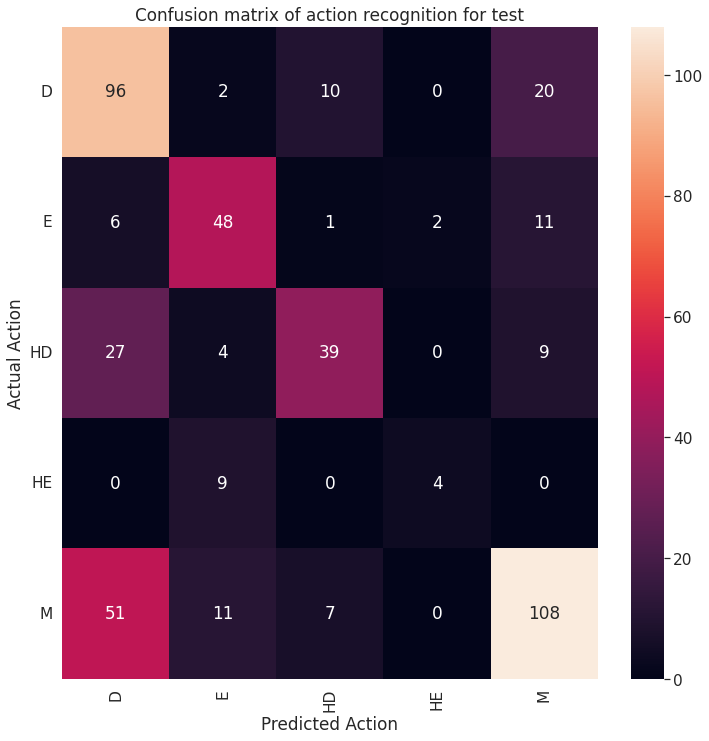

In [45]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')

## Next steps

Now that you have some familiarity with the MoViNet model and how to leverage various TensorFlow APIs (for example, for transfer learning), try using the code in this tutorial with your own dataset. The data does not have to be limited to video data. Volumetric data, such as MRI scans, can also be used with 3D CNNs. The NUSDAT and IMH datasets mentioned in [Brain MRI-based 3D Convolutional Neural Networks for Classification of Schizophrenia and Controls](https://arxiv.org/pdf/2003.08818.pdf) could be two such sources for MRI data.

In particular, using the `FrameGenerator` class used in this tutorial and the other video data and classification tutorials will help you load data into your models.

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)